# Interaction Layout
Apply interaction mapping to Qiskit Staged Pass Manager [layout](https://docs.quantum.ibm.com/api/qiskit/transpiler#layout-stage) using [`AnalysisPass`](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.AnalysisPass)

In [2]:
from lib.interaction_mapping import InteractionMapping

In [19]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeLondonV2
from qiskit.transpiler import CouplingMap, AnalysisPass, Layout, PassManager, StagedPassManager
from qiskit.transpiler.target import Target
from qiskit.dagcircuit import DAGCircuit
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.transpiler.preset_passmanagers.common import generate_embed_passmanager
from qiskit.converters import circuit_to_dag
from qiskit.visualization import plot_coupling_map, plot_circuit_layout

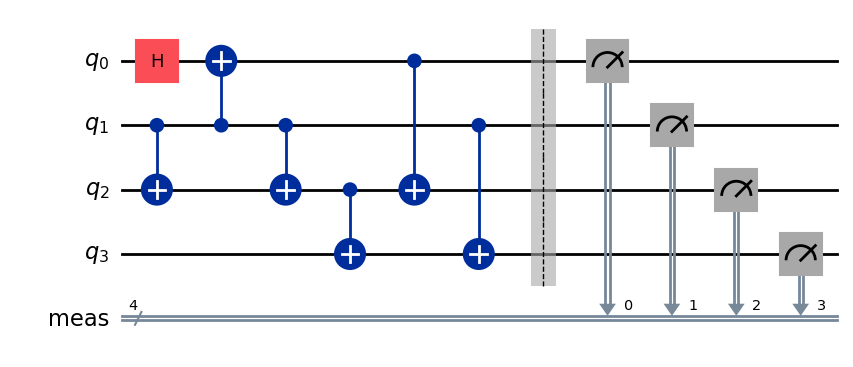

In [14]:
fake_backend = FakeLondonV2()

num_qubits = 4
qc = QuantumCircuit(num_qubits)
qc.h(0)
qc.cx(1, 2)

qc.cx(1, 0)
qc.cx(1, 2)
qc.cx(2, 3)

qc.cx(0, 2)
qc.cx(1, 3)

qc.measure_all()
display(qc.draw('mpl'))

dag = circuit_to_dag(qc)

In [17]:
interaction_mapping = InteractionMapping(coupling_map=fake_backend.coupling_map, dag=dag)
best_layout = interaction_mapping.get_best_qpi_layout()
print("Best mapping layout:", best_layout)

Best mapping layout: [(1, 1), (2, 3), (0, 2), (3, 4)]


In [13]:
class InteractionLayout(AnalysisPass):
    def __init__(self, coupling_map: CouplingMap, initial_map: list[tuple]):        
        super().__init__()
        if isinstance(coupling_map, Target):
            self.target = coupling_map
            self.coupling_map = self.target.build_coupling_map()
            self.initial_map = initial_map
        else:
            self.target = None
            self.coupling_map = coupling_map
            self.initial_map = initial_map

    def build_layout(self, map: list[tuple], dag: DAGCircuit) -> Layout:
        cannonical_register = dag.qregs['q']
        layout = Layout()
        for logical, physical in map:
            layout.add(virtual_bit=cannonical_register[logical], physical_bit=physical)
        return layout

    def run(self, dag: DAGCircuit):
        if self.target is not None:
            if dag.num_qubits() > self.target.num_qubits:
                raise TranspilerError("Number of qubits greater than device.")
        elif dag.num_qubits() > self.coupling_map.size():
            raise TranspilerError("Number of qubits greater than device.")

        layout = self.build_layout(self.initial_map, dag)
        self.property_set["layout"] = layout

        return dag

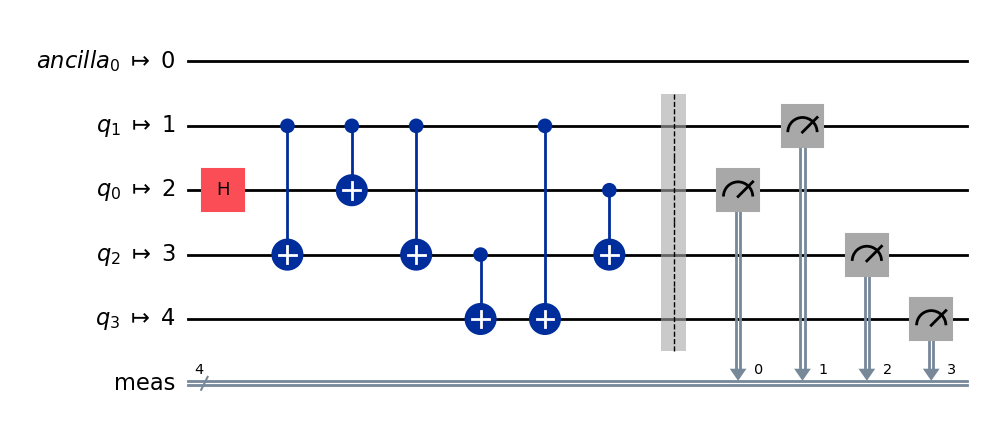

In [21]:
staged_pass = StagedPassManager()

staged_pass.layout = PassManager()
staged_pass.layout += InteractionLayout(coupling_map=fake_backend.coupling_map, initial_map=best_layout)
staged_pass.layout += generate_embed_passmanager(fake_backend.coupling_map)

interaction_isa = staged_pass.run(qc)
display(interaction_isa.draw('mpl'))

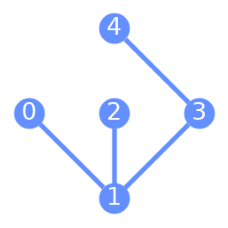

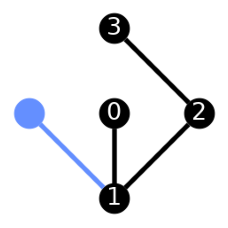

In [24]:
coordinates = [[1, 0], [0, 1], [1, 1], [1, 2], [2, 1]]
display(plot_coupling_map(num_qubits=fake_backend.num_qubits, qubit_coordinates=coordinates, coupling_map=fake_backend.coupling_map.get_edges()))
display(plot_circuit_layout(interaction_isa, fake_backend, view='virtual'))